Importing Necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn  as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.datasets import load_iris


In [2]:
file_path="D:/Github_local/Quantum_ML_mini_project/Classical ML/Cleaned_data.csv"
df=pd.read_csv(file_path)
df.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [6]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
Y = df['Selector'].values
X = df.drop(['Selector'], axis=1).values

X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.25, random_state = algorithm_globals.random_seed)
print("Before Synthetic Generation: ",X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X , Y)
X_train_resampled, X_test_resampled, Y_train_resampled, Y_test_resampled = train_test_split(X_resampled, Y_resampled, test_size=0.25, random_state=42)
print("After Synthetic Generation: ",X_train_resampled.shape, X_test_resampled.shape, Y_train_resampled.shape, Y_test_resampled.shape)

Before Synthetic Generation:  (437, 10) (146, 10) (437,) (146,)
After Synthetic Generation:  (624, 10) (208, 10) (624,) (208,)


In [7]:
svc = SVC().fit(X_train_resampled, Y_train_resampled)

train_score_c4 = svc.score(X_train_resampled, Y_train_resampled)
test_score_c4 = svc.score(X_test_resampled, Y_test_resampled)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.68
Classical SVC on the test dataset:     0.69


Quantum ML

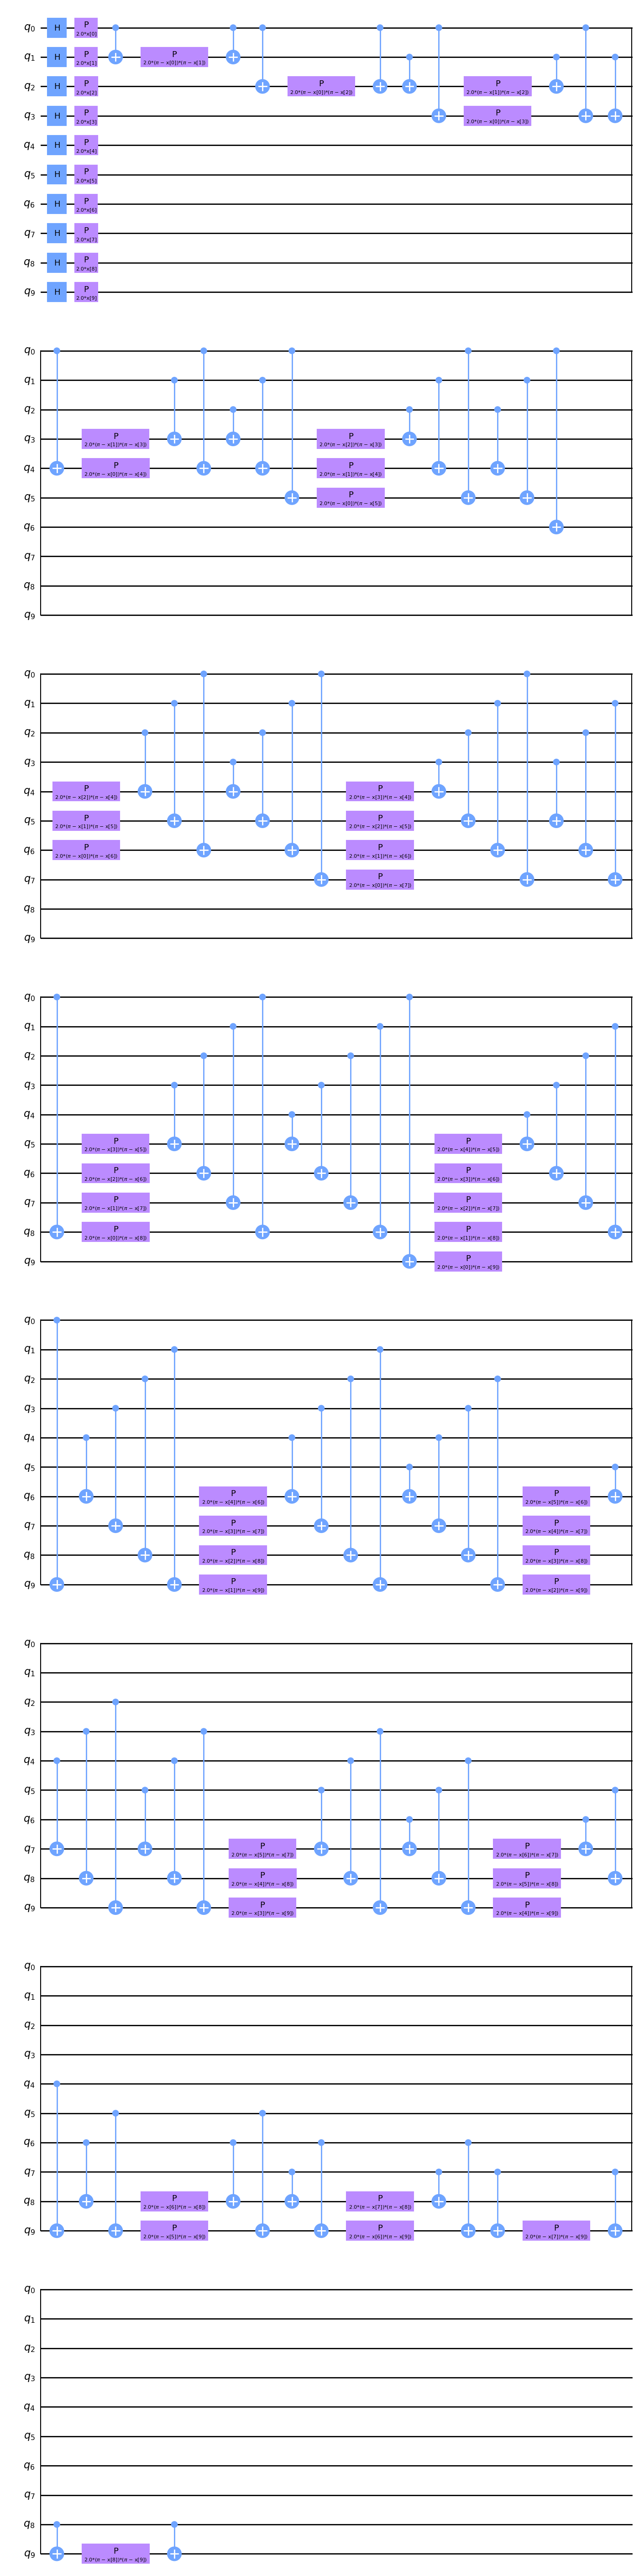

In [8]:
from qiskit.circuit.library import ZZFeatureMap

num_features = X.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

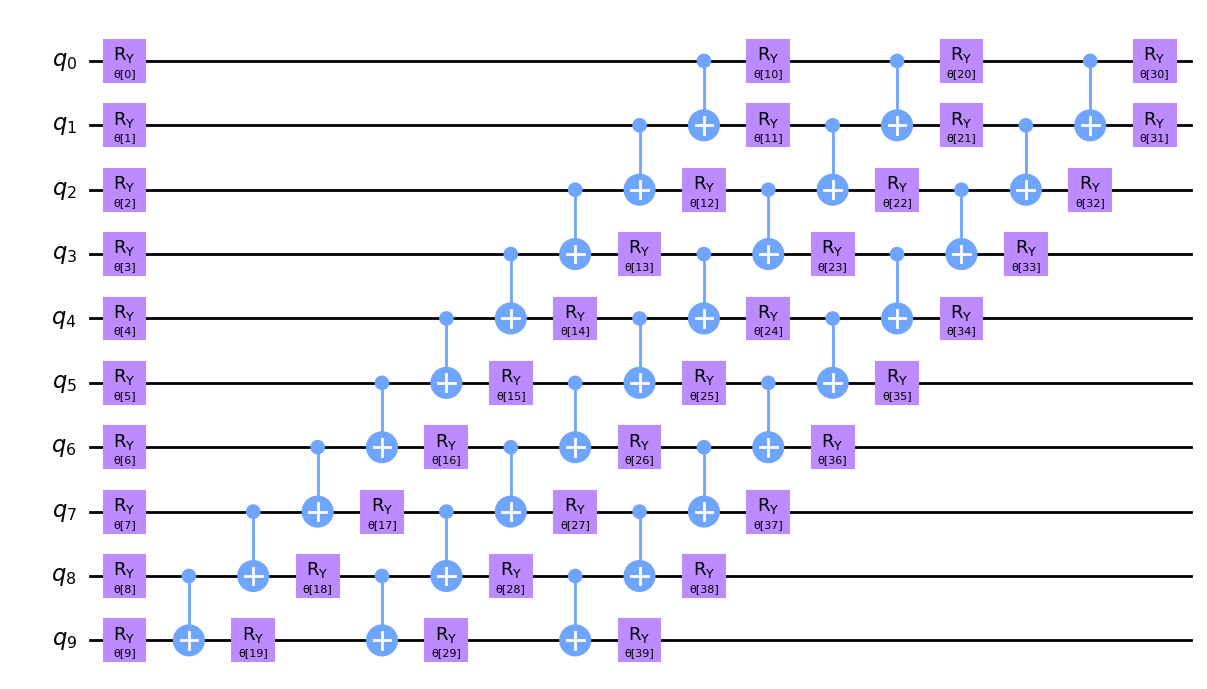

In [9]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [10]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=20)
from qiskit.primitives import Sampler

sampler = Sampler()

In [12]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

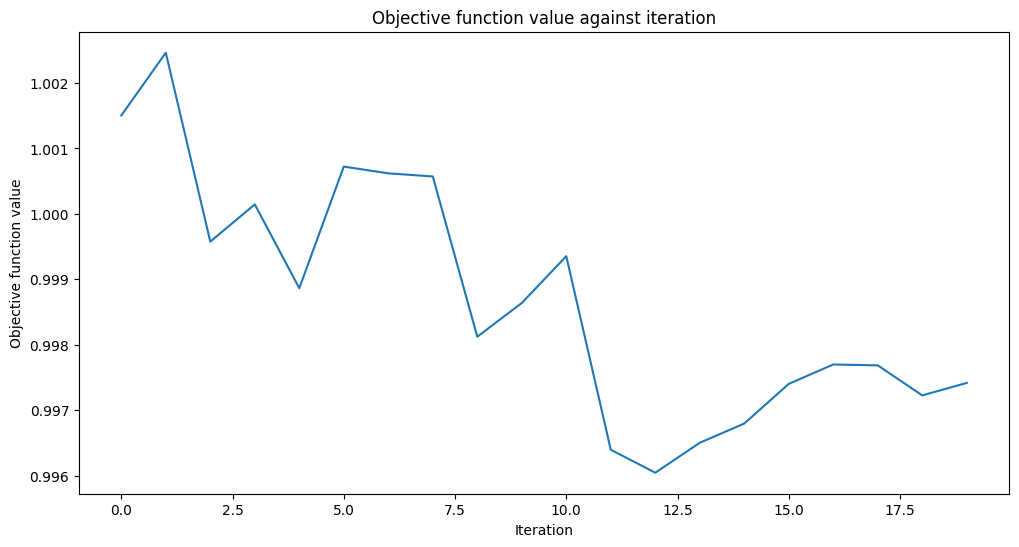

Training time: 408 seconds


In [13]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train_resampled, Y_train_resampled)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [14]:
train_score_q4 = vqc.score(X_train_resampled, Y_train_resampled)
test_score_q4 = vqc.score(X_test_resampled, Y_test_resampled)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.53
Quantum VQC on the test dataset:     0.45


In [17]:
print(objective_func_vals)

[1.00150406826959, 1.0024635274364162, 0.9995768373483196, 1.0001454872160238, 0.9988649132072169, 1.0007231140598978, 1.0006202448376877, 1.0005724949826653, 0.9981234657363589, 0.9986386991832347, 0.9993543835817036, 0.9963961854934297, 0.9960449922507976, 0.9965026723696576, 0.9967966091506173, 0.9974028644332998, 0.9976992045969797, 0.9976855823243858, 0.9972268000637599, 0.9974172915013063]


In [20]:
from sklearn.metrics import classification_report

vqc_pred= vqc.predict(X_test)
vqc_report = classification_report(Y_test, vqc_pred)

print("\nVQC REPORT:\n",vqc_report)


VQC REPORT:
               precision    recall  f1-score   support

           1       0.73      0.57      0.64       102
           2       0.34      0.52      0.41        44

    accuracy                           0.55       146
   macro avg       0.54      0.55      0.53       146
weighted avg       0.62      0.55      0.57       146



In [16]:
vqc.save("vqc_classifier.model")